# Parameter Selection for NMF

Now we look at the more advanced task of parameter selection for NMF topic modelling - namely, selecting a useful value for the number of topics *k*.

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using *Joblib*:

In [1]:
import joblib

(A, terms, snippets) = joblib.load("cenario2-tweets-tfidf.pkl")

print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 400377 X 12367 document-term matrix


### Create the Topic Models

A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of *k*.

We need to start by pre-specifying an initial range of "sensible" values:

In [2]:
kmin, kmax = 5, 20

Apply NMF for each of these values:

In [3]:
from sklearn import decomposition

topic_models = []

# try each value of k
for k in [5,10,15,20]: #range(kmin, kmax + 1):
    print("Applying NMF for k=%d ..." % k)
    # run NMF
    model = decomposition.NMF(init="nndsvd", n_components=k)
    W = model.fit_transform(A)
    H = model.components_
    # store for later
    topic_models.append((k, W, H))

Applying NMF for k=5 ...
Applying NMF for k=10 ...
Applying NMF for k=15 ...
Applying NMF for k=20 ...


### Build a Word Embedding

To select the number of topics, here we will use a *topic coherence* measure called TC-W2V. This measure relies on the use of a *word embedding* model constructed from our corpus. So in this step we will use the *Gensim* implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

**Note:** If you want to skip this step, a pre-built Word2Vec model for the sample dataset [is also provided here for download](http://erdos.ucd.ie/files/pydata/w2v-model.bin) (71MB).

We read the documents from the input file again:

In [4]:
import os.path

raw_documents = []

with open(os.path.join("../../../../../data-pre-processing/2csv/cenario2_8M2020_tweets_en.txt"), "r") as fin:
    for line in fin.readlines():
        raw_documents.append(line.strip().lower())

print("Read %d raw text documents" % len(raw_documents))

Read 400377 raw text documents


Read the custom stopword list:

In [5]:
custom_stop_words = []

with open("english.txt", "r") as fin:
    for line in fin.readlines():
        custom_stop_words.append(line.strip().lower())

# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words))

Stopword list has 179 entries


First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

In [6]:
import re


class TokenGenerator:
    def __init__(self, documents, stopwords):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile(r"(?u)\b\w\w+\b")

    def __iter__(self):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall(doc):
                if tok in self.stopwords:
                    tokens.append("<stopword>")
                elif len(tok) >= 2:
                    tokens.append(tok)
            yield tokens

Now build a Skipgram Word2Vec model from all documents in the input file using *Gensim*:

In [7]:
import gensim

In [8]:
docgen = TokenGenerator(raw_documents, custom_stop_words)

# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [9]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 12577 terms


Save for later use, so that we do not need to rebuild it:

In [10]:
w2v_model.save("cenario2_w2v-model.bin")

In [11]:
# To re-load this model, run
# w2v_model = gensim.models.Word2Vec.load("cenario1_w2v-model.bin")

### Selecting the Number of Topics

Once we have our Word2vec model, we can use it as part of our *topic coherence* approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows:

In [12]:
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

In [13]:
import numpy as np


def get_descriptor(all_terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index, :])[::-1]
    
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    
    for term_index in top_indices[0:top]:
        top_terms.append(all_terms[term_index])
    
    return top_terms

Now process each of the models for different values of *k*:

In [14]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 5))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.3701
K=10: Coherence=0.3186
K=15: Coherence=0.3001
K=20: Coherence=0.2964


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


We can now use *matplotlib* to generate a line plot of these coherence scores, to help us select an appropriate value.

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

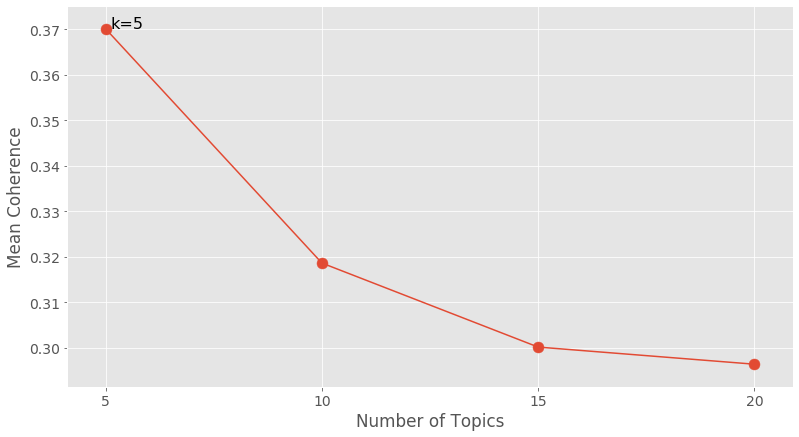

In [16]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 10

In [17]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.3114
K=10: Coherence=0.2756
K=15: Coherence=0.2632
K=20: Coherence=0.2613


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


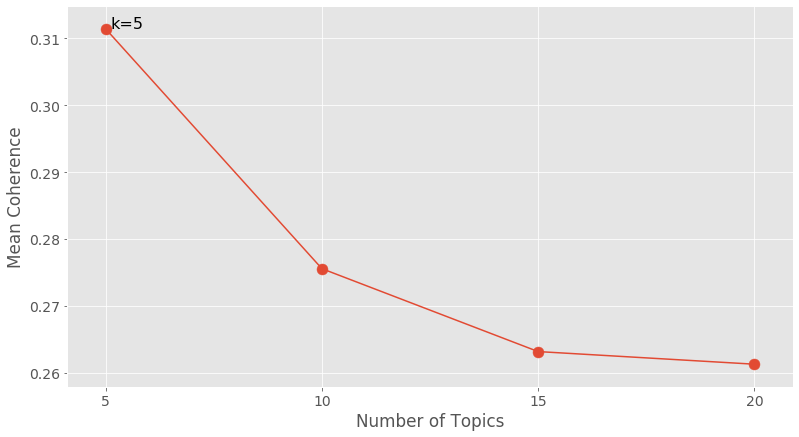

In [18]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 15

In [19]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 15))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.2888
K=10: Coherence=0.2554
K=15: Coherence=0.2495
K=20: Coherence=0.2494


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


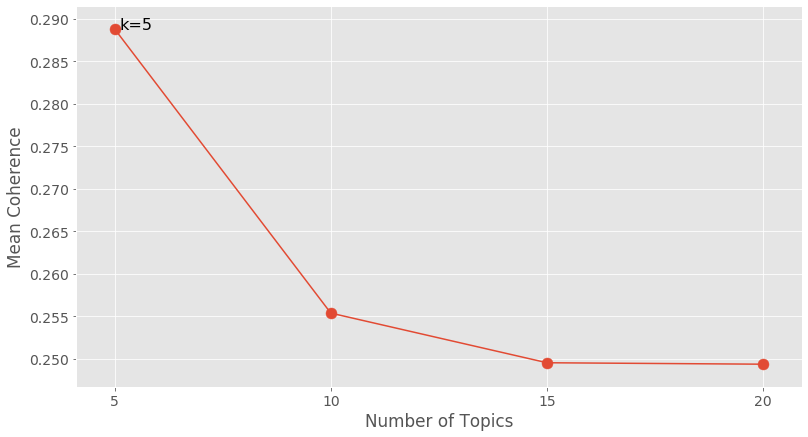

In [20]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 20

In [43]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 20))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


K=05: Coherence=0.2748
K=10: Coherence=0.2430
K=15: Coherence=0.2435
K=20: Coherence=0.2404


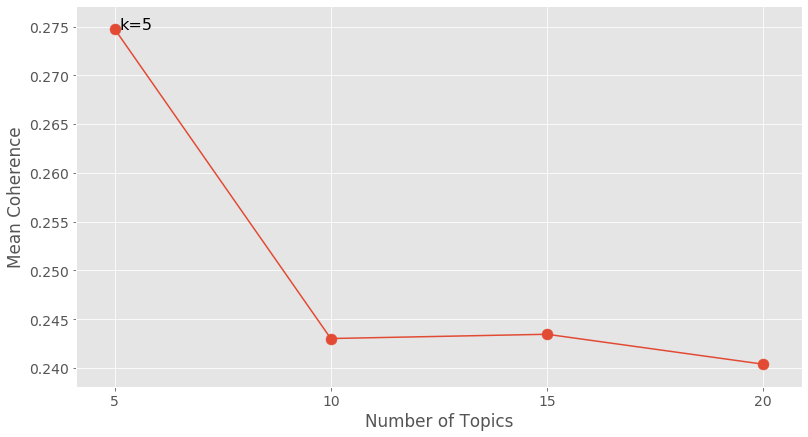

In [44]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

### Examine the Final  Model

The plot above suggests that the most appropriate value for the number of topics is *k=8*.

# 5

In [23]:
k = 5 # best_k

# get the model that we generated earlier.
W = topic_models[0][1]
H = topic_models[0][2]

Display the topic descriptors for this model:

In [24]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, women, womens, every
Topic 02: women, amp, today, celebrate, amazing
Topic 03: happy, ladies, beautiful, strong, women
Topic 04: world, equal, enabled, gender, around
Topic 05: woman, love, every, one, strong


In [25]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, women, womens, every, march, celebrating, celebrate, wishes, special
Topic 02: women, amp, today, celebrate, amazing, work, thank, celebrating, life, strong
Topic 03: happy, ladies, beautiful, strong, women, amazing, everyone, iwd, wishing, wishes
Topic 04: world, equal, enabled, gender, around, equality, let, better, make, celebrate
Topic 05: woman, love, every, one, strong, life, beautiful, much, thank, know


In [26]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, women, womens, every, march, celebrating, celebrate, wishes, special, celebrates, year, via, celebrated, celebration
Topic 02: women, amp, today, celebrate, amazing, work, thank, celebrating, life, strong, many, support, men, great, proud
Topic 03: happy, ladies, beautiful, strong, women, amazing, everyone, iwd, wishing, wishes, wonderful, day, keep, wish, lovely
Topic 04: world, equal, enabled, gender, around, equality, let, better, make, celebrate, create, place, help, achievements, change
Topic 05: woman, love, every, one, strong, life, beautiful, much, thank, know, man, like, day, always, best


In [27]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, women, womens, every, march, celebrating, celebrate, wishes, special, celebrates, year, via, celebrated, celebration, 8th, theme, single, today, achievements
Topic 02: women, amp, today, celebrate, amazing, work, thank, celebrating, life, strong, many, support, men, great, proud, incredible, let, know, girls, make
Topic 03: happy, ladies, beautiful, strong, women, amazing, everyone, iwd, wishing, wishes, wonderful, day, keep, wish, lovely, birthday, team, sisters, queens, may
Topic 04: world, equal, enabled, gender, around, equality, let, better, make, celebrate, create, place, help, achievements, change, girls, together, bias, theme, action
Topic 05: woman, love, every, one, strong, life, beautiful, much, thank, know, man, like, day, always, best, respect, proud, mother, girl, single


# 10

In [28]:
k = 10 # best_k

# get the model that we generated earlier.
W = topic_models[1][1]
H = topic_models[1][2]

In [29]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, womens, women, every
Topic 02: women, strong, celebrating, men, life
Topic 03: happy, ladies, beautiful, day, iwd
Topic 04: world, equal, enabled, gender, around
Topic 05: woman, every, strong, one, life
Topic 06: amp, girls, gender, female, work
Topic 07: love, much, beautiful, respect, life
Topic 08: today, celebrate, let, every, everyday
Topic 09: thank, amazing, work, great, many
Topic 10: thanks, latest, daily, news, great


In [30]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, womens, women, every, march, special, year, celebrates, via
Topic 02: women, strong, celebrating, men, life, may, rights, know, day, incredible
Topic 03: happy, ladies, beautiful, day, iwd, everyone, wishing, wishes, keep, wish
Topic 04: world, equal, enabled, gender, around, equality, let, better, make, place
Topic 05: woman, every, strong, one, life, man, beautiful, know, proud, day
Topic 06: amp, girls, gender, female, work, equality, support, one, like, many
Topic 07: love, much, beautiful, respect, life, ladies, always, one, see, mom
Topic 08: today, celebrate, let, every, everyday, achievements, celebrating, female, equality, day
Topic 09: thank, amazing, work, great, many, much, life, ladies, inspiring, like
Topic 10: thanks, latest, daily, news, great, diario, sharing, much, many, support


In [31]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, womens, women, every, march, special, year, celebrates, via, celebration, celebrated, 8th, theme, great
Topic 02: women, strong, celebrating, men, life, may, rights, know, day, incredible, support, many, inspire, power, proud
Topic 03: happy, ladies, beautiful, day, iwd, everyone, wishing, wishes, keep, wish, wonderful, strong, birthday, lovely, sisters
Topic 04: world, equal, enabled, gender, around, equality, let, better, make, place, create, help, change, girls, together
Topic 05: woman, every, strong, one, life, man, beautiful, know, proud, day, may, like, single, girl, mother
Topic 06: amp, girls, gender, female, work, equality, support, one, like, many, men, time, see, people, get
Topic 07: love, much, beautiful, respect, life, ladies, always, one, see, mom, best, strong, know, mother, show
Topic 08: today, celebrate, let, every, everyday, achievements, celebrating, female, equality, day, way, take, join, year, great
Topic 09: thank, amazing, work, g

In [32]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, womens, women, every, march, special, year, celebrates, via, celebration, celebrated, 8th, theme, great, celebrating, one, single, wishes, enjoy
Topic 02: women, strong, celebrating, men, life, may, rights, know, day, incredible, support, many, inspire, power, proud, inspiring, wonderful, powerful, respect, lives
Topic 03: happy, ladies, beautiful, day, iwd, everyone, wishing, wishes, keep, wish, wonderful, strong, birthday, lovely, sisters, team, queens, friends, female, favorite
Topic 04: world, equal, enabled, gender, around, equality, let, better, make, place, create, help, change, girls, together, theme, achievements, bias, collectively, action
Topic 05: woman, every, strong, one, life, man, beautiful, know, proud, day, may, like, single, girl, mother, powerful, never, best, first, without
Topic 06: amp, girls, gender, female, work, equality, support, one, like, many, men, time, see, people, get, need, good, proud, also, still
Topic 07: love, much, be

# 15

In [33]:
k = 15 # best_k

# get the model that we generated earlier.
W = topic_models[2][1]
H = topic_models[2][2]

In [34]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, womens, march, women
Topic 02: women, day, life, rights, incredible
Topic 03: happy, ladies, day, everyone, iwd
Topic 04: world, equal, enabled, around, gender
Topic 05: woman, life, man, power, mother
Topic 06: amp, girls, support, many, sisters
Topic 07: love, much, respect, life, ladies
Topic 08: today, celebrate, let, everyday, achievements
Topic 09: thank, much, wonderful, life, inspiring
Topic 10: thanks, latest, daily, news, diario
Topic 11: strong, beautiful, may, know, raise
Topic 12: one, great, work, like, equality
Topic 13: amazing, ladies, work, life, many
Topic 14: every, day, single, inspire, year
Topic 15: celebrating, achievements, female, today, join


In [35]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, womens, march, women, via, celebrates, special, celebration, 8th
Topic 02: women, day, life, rights, incredible, men, power, wonderful, inspire, support
Topic 03: happy, ladies, day, everyone, iwd, wishing, wishes, wish, keep, wonderful
Topic 04: world, equal, enabled, around, gender, better, equality, let, place, create
Topic 05: woman, life, man, power, mother, first, wonder, inspires, magic, god
Topic 06: amp, girls, support, many, sisters, friends, life, family, health, strength
Topic 07: love, much, respect, life, ladies, always, mom, beautiful, mother, see
Topic 08: today, celebrate, let, everyday, achievements, take, lives, join, way, incredible
Topic 09: thank, much, wonderful, life, inspiring, support, incredible, making, everything, always
Topic 10: thanks, latest, daily, news, diario, much, sharing, special, great, many
Topic 11: strong, beautiful, may, know, raise, powerful, ladies, life, independent, stay
Topic 12: one, great, work, like, equa

In [36]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, womens, march, women, via, celebrates, special, celebration, 8th, theme, celebrated, year, enjoy, yesterday
Topic 02: women, day, life, rights, incredible, men, power, wonderful, inspire, support, respect, lives, empower, inspiring, trans
Topic 03: happy, ladies, day, everyone, iwd, wishing, wishes, wish, keep, wonderful, birthday, lovely, team, sisters, beautiful
Topic 04: world, equal, enabled, around, gender, better, equality, let, place, create, make, help, change, achievements, bias
Topic 05: woman, life, man, power, mother, first, wonder, inspires, magic, god, strength, tag, strongest, without, never
Topic 06: amp, girls, support, many, sisters, friends, life, family, health, strength, mother, community, join, respect, working
Topic 07: love, much, respect, life, ladies, always, mom, beautiful, mother, see, appreciate, sending, show, heart, best
Topic 08: today, celebrate, let, everyday, achievements, take, lives, join, way, incredible, tomorrow, hon

In [37]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, womens, march, women, via, celebrates, special, celebration, 8th, theme, celebrated, year, enjoy, yesterday, equality, post, message, mens, mark
Topic 02: women, day, life, rights, incredible, men, power, wonderful, inspire, support, respect, lives, empower, inspiring, trans, wishes, around, inspirational, society, powerful
Topic 03: happy, ladies, day, everyone, iwd, wishing, wishes, wish, keep, wonderful, birthday, lovely, team, sisters, beautiful, queens, friends, favorite, girls, incredible
Topic 04: world, equal, enabled, around, gender, better, equality, let, place, create, make, help, change, achievements, bias, theme, collectively, forge, together, across
Topic 05: woman, life, man, power, mother, first, wonder, inspires, magic, god, strength, tag, strongest, without, never, proud, ever, tell, another, powerful
Topic 06: amp, girls, support, many, sisters, friends, life, family, health, strength, mother, community, join, respect, working, share, ot

# 20

In [38]:
k = 20 # best_k

# get the model that we generated earlier.
W = topic_models[3][1]
H = topic_models[3][2]

In [39]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, womens, march, women
Topic 02: women, day, life, incredible, men
Topic 03: happy, day, everyone, iwd, wishes
Topic 04: world, equal, enabled, around, better
Topic 05: woman, man, life, power, first
Topic 06: amp, support, sisters, friends, life
Topic 07: love, much, respect, life, always
Topic 08: today, celebrate, everyday, let, achievements
Topic 09: thank, much, wonderful, life, inspiring
Topic 10: thanks, latest, daily, news, diario
Topic 11: strong, beautiful, powerful, life, independent
Topic 12: amazing, life, many, shout, work
Topic 13: work, proud, like, girls, female
Topic 14: every, day, single, inspire, year
Topic 15: celebrating, achievements, today, join, female
Topic 16: ladies, lovely, wonderful, keep, let
Topic 17: equality, gender, let, equal, rights
Topic 18: great, see, hope, event, things
Topic 19: may, know, raise, strong, continue
Topic 20: one, best, another, life, year


In [40]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, womens, march, women, via, celebrates, celebration, special, 8th
Topic 02: women, day, life, incredible, men, rights, power, wonderful, inspire, respect
Topic 03: happy, day, everyone, iwd, wishes, wishing, wish, birthday, keep, sisters
Topic 04: world, equal, enabled, around, better, place, make, create, help, change
Topic 05: woman, man, life, power, first, mother, wonder, inspires, magic, god
Topic 06: amp, support, sisters, friends, life, strength, many, mother, respect, health
Topic 07: love, much, respect, life, always, mom, see, mother, sending, appreciate
Topic 08: today, celebrate, everyday, let, achievements, way, lives, take, join, tomorrow
Topic 09: thank, much, wonderful, life, inspiring, support, everything, making, always, inspiration
Topic 10: thanks, latest, daily, news, diario, much, sharing, special, support, many
Topic 11: strong, beautiful, powerful, life, independent, brave, stay, smart, intelligent, kind
Topic 12: amazing, life, many

In [41]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, womens, march, women, via, celebrates, celebration, special, 8th, year, celebrated, theme, enjoy, yesterday
Topic 02: women, day, life, incredible, men, rights, power, wonderful, inspire, respect, lives, empower, trans, wishes, support
Topic 03: happy, day, everyone, iwd, wishes, wishing, wish, birthday, keep, sisters, team, queens, friends, wonderful, incredible
Topic 04: world, equal, enabled, around, better, place, make, create, help, change, making, run, across, forge, collectively
Topic 05: woman, man, life, power, first, mother, wonder, inspires, magic, god, tag, never, strength, strongest, without
Topic 06: amp, support, sisters, friends, life, strength, many, mother, respect, health, family, join, girls, community, share
Topic 07: love, much, respect, life, always, mom, see, mother, sending, appreciate, show, heart, strength, sisters, womens
Topic 08: today, celebrate, everyday, let, achievements, way, lives, take, join, tomorrow, incredible, aroun

In [42]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, womens, march, women, via, celebrates, celebration, special, 8th, year, celebrated, theme, enjoy, yesterday, post, video, mens, message, mark
Topic 02: women, day, life, incredible, men, rights, power, wonderful, inspire, respect, lives, empower, trans, wishes, support, inspiring, around, society, inspirational, powerful
Topic 03: happy, day, everyone, iwd, wishes, wishing, wish, birthday, keep, sisters, team, queens, friends, wonderful, incredible, favorite, sunday, lovely, everyday, dear
Topic 04: world, equal, enabled, around, better, place, make, create, help, change, making, run, across, forge, collectively, cup, without, girls, achievements, theme
Topic 05: woman, man, life, power, first, mother, wonder, inspires, magic, god, tag, never, strength, strongest, without, tell, know, right, ever, stands
Topic 06: amp, support, sisters, friends, life, strength, many, mother, respect, health, family, join, girls, community, share, others, new, role, continu